In [1]:
get_ipython().system('pip install hurst fbprophet matplotlib yfinance numpy statsmodels datetime pandas_market_calendars')


In [2]:


import yfinance
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime as dt
import datetime
from datetime import timedelta
from datetime import date
import pandas_ta as ta
import statsmodels.tsa.stattools as ts
from statsmodels import regression
import statsmodels.api as sm
from hurst import compute_Hc
from fbprophet import Prophet
import pandas_market_calendars as mcal
from finta import TA

import os.path
from os import path

from scipy.stats import ttest_ind
from numpy import cumsum

import concurrent.futures
from concurrent.futures import wait, ALL_COMPLETED


from statsmodels.tsa.api import ExponentialSmoothing, SimpleExpSmoothing, Holt
%matplotlib inline

pd.set_option('display.max_columns', None) #replace n with the number of columns you want to see completely
pd.set_option('display.max_rows', None) #replace n with the number of rows you want to see completely


Importing plotly failed. Interactive plots will not work.


In [3]:


n_forward = 4
#name = 'BTC-USD'
#name = 'GLD'
name = 'SPY'
#name = 'GOOG'

#strategy = "EMA"
strategy = "SMA"
#indicator = 'Close'
indicator = 'VWP'

w=117
end_date = datetime.date.today()
#end_date = datetime.date.today() - timedelta(weeks=w)
end_date1 = end_date - timedelta(weeks=w)
start_date = end_date1 - timedelta(weeks=w)


In [4]:
cores = int(len(os.sched_getaffinity(0)))

nyse = mcal.get_calendar('NYSE')
nyse_trading_dates= nyse.schedule(start_date=start_date, end_date=(end_date+timedelta(days=n_forward+5)))

ticker = yfinance.Ticker(name)
data = ticker.history(interval="1d",start=start_date,end=end_date+timedelta(days=1), auto_adjust=True)
data['Forward Close'] = data['Close'].shift(-n_forward)
data['Forward Return'] = (data['Forward Close'] - data['Close'])/data['Close']
data['VWP'] = data['Close']*data['Volume']

Short_EVWMA = pd.DataFrame(TA.EVWMA(data,12))
Long_EVWMA = pd.DataFrame(TA.EVWMA(data,26))
Short_EVWMA.columns = ['EVWMA_12']
Long_EVWMA.columns = ['EVWMA_26']

#p 209 of ttr doc
MACD_EVWMA = pd.DataFrame((Short_EVWMA['EVWMA_12'] - Long_EVWMA['EVWMA_26'])/(Long_EVWMA['EVWMA_26']))
MACD_EVWMA.columns = ['MACD-line']

Signal_EVWMA = pd.DataFrame(ta.ema(MACD_EVWMA["MACD-line"], length=9))
Signal_EVWMA.columns = ['Signal_EMA_9_MACD']
data['MACD_Signal'] = Signal_EVWMA

benchName = "^GSPC"
bench = yfinance.Ticker(benchName)
#bench Data needs to be +1 because it ends the day before end_date
benchData = bench.history(interval="1d",start=start_date,end=end_date+timedelta(days=1), auto_adjust=True)

len(benchData)
len(data)



1635

In [5]:


dateindex = data.loc[start_date:end_date].index

dateindex_n_forward = [start_date + datetime.timedelta(days=x) for x in range(0, ((end_date+ timedelta(days=n_forward+5))-start_date).days)]




In [6]:

if(len(data)>len(nyse_trading_dates)):
    frequency=pd.DataFrame(dateindex_n_forward).set_index(0).index
    frequency = pd.to_datetime(frequency, errors='coerce',format='%Y-%m-%d')
    
else:
    frequency=nyse_trading_dates.reset_index().set_index('index').rename_axis([None]).index

#https://stackoverflow.com/questions/40815238/python-pandas-convert-index-to-datetime
#frequency = pd.to_datetime(frequency, errors='coerce')


In [7]:
#will help later with bad data during loops

prices = benchData
df = prices.rename_axis([None]).reindex(pd.DataFrame(frequency).set_index(0)[start_date:end_date].index)
df = df.reindex(frequency)
df['Volume'] = df['Volume'].replace('0', np.NaN)#.interpolate(method='time')
df.index = pd.to_datetime(df.index, errors='coerce',format='%Y-%m-%d')
df = df.interpolate(method='time')
df = df.dropna()
benchData = df[start_date.strftime('%Y-%m-%d'):end_date.strftime('%Y-%m-%d')]



In [8]:
#will help later with bad data during loops

prices = data
df = prices.rename_axis([None]).reindex(pd.DataFrame(frequency).set_index(0)[start_date:end_date].index)
df['Volume'] = df['Volume'].replace('0', np.NaN)
df.index = pd.to_datetime(df.index, errors='coerce',format='%Y-%m-%d')
df = df.reindex(frequency)
df = df.interpolate(method='time')
df = df.dropna()
df = df[start_date.strftime('%Y-%m-%d'):end_date.strftime('%Y-%m-%d')]

#n_forward*2-1 day trend data (-1 due dropping na)
trend_data_pd = pd.DataFrame()

for iterator in range(0,len(df)-(n_forward*2-1)):
    
    temp = pd.DataFrame()
    
    inner_prices = df.iloc[iterator:(iterator+n_forward*2)]
    #print(inner_prices.tail())
    
    ret_data =  inner_prices['Close'].pct_change()
    cumulative_ret_data = (ret_data + 1).cumprod()
    
    adf_results = ts.adfuller(ret_data.dropna(), 1)
    
    if(adf_results[1]>.05):
        
        # Find the line of best fit to illustrate the trend
        X = np.arange(len(cumulative_ret_data.dropna()))
        x = sm.add_constant(X) # Add a column of ones so that line can have a y-intercept
        model = regression.linear_model.OLS(cumulative_ret_data.dropna(), x).fit()
        a = model.params[0] # Get coefficients of line
        b = model.params[1]
        trend_data = X * b + a
        
        #print(b)
        #favorable trend
        if((b>0) & (trend_data[-1]>1)):
            temp['Date'] = [inner_prices.index[-1]]
            temp['trend'] = [1]
        else:
            temp['Date'] = [inner_prices.index[-1]]
            temp['trend'] = [0]    
    else:
        temp['Date'] = [inner_prices.index[-1]]
        temp['trend'] = [0]    

        #if(trend_data[-1]>1):            
            #plt.plot(cumulative_ret_data.dropna(), 'r', alpha=0.9)
            #plt.plot(pd.DataFrame(trend_data).set_index(cumulative_ret_data.dropna().index))
            #print(a)
            #print(b)
            #print(trend_data[-1])
            #plt.xticks(rotation=30) 
            #plt.show()
    #print(temp)
    trend_data_pd = pd.concat([trend_data_pd,temp])
    #print(len(inner_prices))

#makes no sense to do with n_forward
    #H, c, val = compute_Hc(temp[innerIndicator], kind='price', simplified=True)            

df['trend'] = trend_data_pd.set_index('Date')
data = df.dropna()
#data = df[start_date:end_date]


In [17]:

limit = 100

train_size = 0.5

minExpectedReturn = 0

#width1 = len(benchData.loc[start_date:end_date1].index)

#based on benchData, but with na's dropped
width1 = len(data.loc[start_date:end_date1].index)
width2 = len(benchData.loc[end_date1+timedelta(days=1):end_date].index)

fb = True

strat = True

#for i in range(0,width1):
#for i in range(665,669):    
#for i in [range(0,width1)[-1]]:
def processSet(i): 
    #print(i)
    trades3 = pd.DataFrame()
    #print(trades3)
    
    temp = data.loc[frequency[i]:frequency[i+width2]].copy()        
    
    #print(temp.iloc[-1])
    #print(temp.index[-1])

    innerIndicator = 'Close'
    #not sure if kind should be price
    #adf_results = ts.adfuller(temp[innerIndicator], 1)
    
    #makes no sense to do with n_forward
    #H, c, val = compute_Hc(temp[innerIndicator], kind='price', simplified=True)                
    
    if fb:        
        
        ts1 = pd.DataFrame()
        ts1["Date"] = temp.index
        ts1['y'] = temp[innerIndicator].values
        ts1.columns = ['ds', 'y']

        #no need to strip last day from model becuase df_inner (which ts is based on) is already -2
        m = Prophet(daily_seasonality=True,yearly_seasonality=True)
        m.add_seasonality(name='monthly', period=30.5, fourier_order=5)
        m.add_seasonality(name='quarterly', period=91.25, fourier_order=7)
        m.fit(ts1)

        dateToBeSold = frequency[frequency.get_loc(temp.index[-1].strftime('%Y-%m-%d'))+n_forward].strftime('%Y-%m-%d')
        nextDay = frequency[frequency.get_loc(temp.index[-1])+1].strftime('%Y-%m-%d')
        forecast = pd.DataFrame(pd.DataFrame(frequency)[0][(pd.DataFrame(frequency)[0] <= dateToBeSold) & (pd.DataFrame(frequency)[0] >= nextDay)])
        forecast.columns = ['ds']

        #Predict and plot
        pred = m.predict(forecast)['yhat']
        pred = pd.DataFrame(pred)
        pred.columns = [innerIndicator]
        
        predRet = ((pred.iloc[-1][0] - temp.iloc[-1][innerIndicator])/temp.iloc[-1][innerIndicator])
        
    result = []
    
    for ma_length in range(20,limit):        
        
        if strategy == "EMA":
            
            temp[strategy] = ta.ema(temp[indicator], length=ma_length)
            temp['input'] = [int(x) for x in temp[indicator] > temp[strategy]]
            
        elif strategy == "SMA":
            
            temp[strategy] = temp[indicator].rolling(ma_length).mean()
            temp['input'] = [int(x) for x in temp[indicator] > temp[strategy]]                
        
        training = temp.head(int(train_size * temp.shape[0]))
        test = temp.tail(int((1 - train_size) * temp.shape[0]))
        
        tr_returns = training[training['input'] == 1]['Forward Return']
        test_returns = test[test['input'] == 1]['Forward Return']
        
        mean_forward_return_training = tr_returns.mean()
        mean_forward_return_test = test_returns.mean()
        
        if (len(tr_returns) < 2) | (len(test_returns) < 2):
            pvalue = 0
                    
        else:
            pvalue = ttest_ind(tr_returns,test_returns,equal_var=False)[1]

        result.append({
            'ma_length':ma_length,
            'training_forward_return': mean_forward_return_training,
            'test_forward_return': mean_forward_return_test,
            'p-value':pvalue
        })
        
        
    result.sort(key = lambda x : -x['training_forward_return'])
    
    if strategy == "EMA":
        temp[strategy] = ta.ema(temp[indicator], length=result[0]['ma_length'])
        
    elif strategy == "SMA":
        temp[strategy] = temp[indicator].rolling(result[0]['ma_length']).mean()        

    temp['inputMACD'] = [int(x) for x in temp['MACD_Signal'] > 0]

    #df = temp.dropna()

    training_ = temp.head(int(train_size * temp.shape[0]))
    test_ = temp.tail(int((1 - train_size) * temp.shape[0]))

    tr_returns_MACD = training_[training_['inputMACD'] == 1]['Forward Return']
    test_returns_MACD = test_[test_['inputMACD'] == 1]['Forward Return']
    
    tr_returns_trend = training_[training_['trend'] == 1]['Forward Return']
    test_returns_trend = test_[test_['trend'] == 1]['Forward Return']
    
    mean_forward_return_training_MACD = tr_returns_MACD.mean()
    mean_forward_return_test_MACD = test_returns_MACD.mean()
    
    mean_forward_return_training_trend = tr_returns_trend.mean()
    mean_forward_return_test_trend = test_returns_trend.mean()

    if (len(tr_returns_MACD) < 2) | (len(test_returns_MACD) < 2):
        pvalue_MACD = 0

    else:
        pvalue_MACD = ttest_ind(tr_returns_MACD,test_returns_MACD,equal_var=False)[1]        
    
    trade = pd.DataFrame()
    
    if fb:                
        
        if (predRet >= 0):
            #print("fb")
            
            trade = pd.DataFrame()
            trade['Date'] = [temp.index[-1].strftime('%Y-%m-%d')]
            trade['Type'] = ['fbProphet']
            trade['expRet'] = [predRet]
            trade['sdev'] = ['']
            trades3 = pd.concat([trades3,trade])
    
    trade = pd.DataFrame()
    if ((pvalue_MACD > .05) and (temp.iloc[-1]['MACD_Signal'] > 0)):
        #print("macd")
        if (mean_forward_return_training_MACD > minExpectedReturn and mean_forward_return_test_MACD > minExpectedReturn):
            trade = pd.DataFrame()
            trade['Date'] = [temp.index[-1].strftime('%Y-%m-%d')]
            trade['Type'] = ['MACD']            
            trade['expRet'] = [(mean_forward_return_training_MACD + mean_forward_return_test_MACD)/2]
            trade['sdev'] = [np.std(temp['Forward Return'])]
            #trade['sdev'] = ['']
            trades3 = pd.concat([trades3,trade])            

    trade = pd.DataFrame()
    if (temp.iloc[-1]['trend']== 1):
        #print("trend")
        trade = pd.DataFrame()
        trade['Date'] = [temp.index[-1].strftime('%Y-%m-%d')]
        trade['Type'] = ['trend']
        trade['expRet'] = [(mean_forward_return_training_trend + mean_forward_return_test_trend)/2]
        trade['sdev'] = ['']
        trades3 = pd.concat([trades3,trade])


    if strat:
        if (result[0]['p-value'] > .05 and temp.iloc[-1][indicator]>temp.iloc[-1][strategy]):

            if (result[0]['training_forward_return'] > minExpectedReturn and result[0]['test_forward_return'] > minExpectedReturn):

                trade = pd.DataFrame()
                trade['Date'] = [temp.index[-1]]
                trade['Type'] = [strategy]
                trade['expRet'] = [((result[0]['training_forward_return']+result[0]['test_forward_return'])/2)]
                trade['sdev'] = [np.std(temp['Forward Return'])]
                trades3 = pd.concat([trades3,trade])
        
    #print(trades3)
    #trades2 = pd.concat([trades3,f.result()])
    return trades3

pool1 = concurrent.futures.ProcessPoolExecutor(cores)

futures1 = [pool1.submit(processSet, args) for args in range(0,width1)]

wait(futures1, timeout=None, return_when=ALL_COMPLETED)



DoneAndNotDoneFutures(done={<Future at 0x7fbe3ea90080 state=finished returned DataFrame>, <Future at 0x7fbe3e9e0080 state=finished returned DataFrame>, <Future at 0x7fbe3ea900b8 state=finished returned DataFrame>, <Future at 0x7fbe3e9e0128 state=finished returned DataFrame>, <Future at 0x7fbe3ebee860 state=finished returned DataFrame>, <Future at 0x7fbe3e9e01d0 state=finished returned DataFrame>, <Future at 0x7fbe3eb48240 state=finished returned DataFrame>, <Future at 0x7fbe3eb48278 state=finished returned DataFrame>, <Future at 0x7fbe3e9e0278 state=finished returned DataFrame>, <Future at 0x7fbe3eb70320 state=finished returned DataFrame>, <Future at 0x7fbe3eb48320 state=finished returned DataFrame>, <Future at 0x7fbe3e9e0320 state=finished returned DataFrame>, <Future at 0x7fbe3eb98358 state=finished returned DataFrame>, <Future at 0x7fbe3eb70358 state=finished returned DataFrame>, <Future at 0x7fbe3eb48358 state=finished returned DataFrame>, <Future at 0x7fbe3e9e03c8 state=finished r

Process Process-17:
Process Process-23:
Process Process-30:
Process Process-25:
Process Process-27:
Process Process-24:
Process Process-22:
Process Process-32:
Process Process-29:
Process Process-28:
Process Process-20:
Process Process-19:
Process Process-21:
Process Process-26:
Process Process-31:
Process Process-18:
Traceback (most recent call last):


In [18]:
trades2 = pd.DataFrame()

for f in futures1:
    #throwing a weird date error with one dataframe (had date outside of range)
    #rint(f.result())
    trades2 = pd.concat([trades2,f.result()])
    

In [19]:
trades2.head().append(trades2.tail())

,Date,Type,expRet,sdev
0,2018-12-16,fbProphet,1.143451,
0,2018-12-17,fbProphet,0.883689,
0,2018-12-18,fbProphet,0.743457,
0,2018-12-18,trend,0.014392,
0,2018-12-19,fbProphet,0.522070,
0,2021-02-09,MACD,0.022423,0.076837
0,2021-02-09 00:00:00,SMA,0.019302,0.076837
0,2021-02-10,MACD,0.022528,0.0767219
0,2021-02-10,trend,0.022387,
0,2021-02-10 00:00:00,SMA,0.019428,0.0767219


In [20]:
len(trades2[trades2['Type']==strategy])

106

(array([ 5.,  2.,  3.,  3.,  2.,  8., 12., 25., 21., 14., 11.]),
 array([0.00893655, 0.01003592, 0.01113529, 0.01223467, 0.01333404,
        0.01443341, 0.01553278, 0.01663215, 0.01773152, 0.01883089,
        0.01993027, 0.02102964]),
 <a list of 11 Patch objects>)

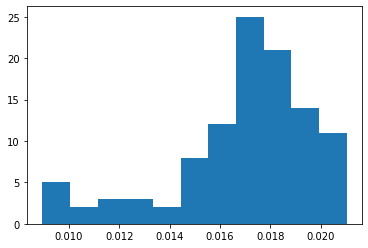

In [21]:
#trades2[trades2['Type']=='fbProphet']
#trades2.Type.unique()
#

plt.hist(trades2[trades2['Type']==strategy]['expRet'], bins='auto')  # arguments are passed to np.histogram

,Type,expRet,sdev
Date,,,
2018-12-18,trend,0.014497,
2018-12-19,trend,0.014907,
2018-12-20,trend,0.014557,
2019-01-06,trend,0.012904,
2019-02-04,trend,0.010227,
2019-02-08,trend,0.010258,
2019-02-09,trend,0.010233,
2019-02-10,trend,0.010048,
2019-02-11,trend,0.010049,


In [22]:


set = pd.DataFrame()
for i in range(0,len(trades2)):
    value = pd.DataFrame(data.loc[trades2.iloc[i]['Date']]).transpose()
    #pd.DataFrame(data.loc[pd.to_datetime(trades2.iloc[i]['Date'], errors='coerce').date()]).transpose().reset_index(drop=True)
    #value = pd.DataFrame(data.loc[trades2.iloc[i]['Date']]).transpose().reset_index(drop=True)
    value['index'] = i
    value['type'] = trades2.iloc[i]['Type']
    value['Date'] = trades2.iloc[i]['Date']
    value['ExpectedReturn'] = [trades2.iloc[i]['expRet']]
    value['sdev'] = trades2.iloc[i]['sdev']
    set = pd.concat([set,value.set_index('index')])




In [17]:
set.head().append(set.tail())

,Open,High,Low,Close,Volume,Dividends,Stock Splits,Forward Close,Forward Return,VWP,MACD_Signal,trend,type,Date,ExpectedReturn,sdev
index,,,,,,,,,,,,,,,,
0,3544.761475,3701.349365,3487.169189,3696.059082,5.911325e+09,0.0,0.0,4014.182617,0.086071,2.184861e+13,-0.147235,1.0,trend,2018-12-18,0.014497,
1,3706.824951,3949.322998,3687.229980,3745.950684,6.810689e+09,0.0,0.0,3998.980225,0.067547,2.551251e+13,-0.147274,1.0,trend,2018-12-19,0.014907,
2,3742.195068,4191.228516,3728.974609,4134.441406,8.927129e+09,0.0,0.0,4078.599121,-0.013507,3.690869e+13,-0.144486,1.0,trend,2018-12-20,0.014557,
3,3836.519043,4093.297363,3826.513184,4076.632568,5.597027e+09,0.0,0.0,3678.924561,-0.097558,2.281702e+13,-0.084277,1.0,trend,2019-01-06,0.012904,
4,3467.211670,3476.223877,3442.586914,3459.154053,5.332719e+09,0.0,0.0,3666.780273,0.060022,1.844670e+13,-0.054726,1.0,trend,2019-02-04,0.010227,
500,47114.507812,49487.640625,47114.507812,48717.289062,7.124868e+10,0.0,0.0,51679.796875,0.060810,3.471042e+15,0.097703,0.0,MACD,2021-02-14,0.022726,0.0761452
501,48696.535156,48875.570312,46347.476562,47945.058594,7.706990e+10,0.0,0.0,55888.132812,0.165670,3.695121e+15,0.101426,0.0,MACD,2021-02-15,0.022958,0.0758713
502,47944.457031,50341.101562,47201.304688,49199.871094,7.704958e+10,0.0,0.0,56099.519531,0.140237,3.790830e+15,0.104792,0.0,MACD,2021-02-16,0.023148,0.0758763
503,49207.277344,52533.914062,49072.378906,52149.007812,8.082055e+10,0.0,0.0,57539.945312,0.103376,4.214711e+15,0.108213,1.0,MACD,2021-02-17,0.023278,0.0757722


,Open,High,Low,Close,Volume,Dividends,Stock Splits,Forward Close,Forward Return,VWP,MACD_Signal,trend,type,Date,ExpectedReturn,sdev
index,,,,,,,,,,,,,,,,
0,3544.761475,3701.349365,3487.169189,3696.059082,5.911325e+09,0.0,0.0,4014.182617,0.086071,2.184861e+13,-0.147235,1.0,trend,2018-12-18,0.014497,
1,3706.824951,3949.322998,3687.229980,3745.950684,6.810689e+09,0.0,0.0,3998.980225,0.067547,2.551251e+13,-0.147274,1.0,trend,2018-12-19,0.014907,
2,3742.195068,4191.228516,3728.974609,4134.441406,8.927129e+09,0.0,0.0,4078.599121,-0.013507,3.690869e+13,-0.144486,1.0,trend,2018-12-20,0.014557,
3,3836.519043,4093.297363,3826.513184,4076.632568,5.597027e+09,0.0,0.0,3678.924561,-0.097558,2.281702e+13,-0.084277,1.0,trend,2019-01-06,0.012904,
4,3467.211670,3476.223877,3442.586914,3459.154053,5.332719e+09,0.0,0.0,3666.780273,0.060022,1.844670e+13,-0.054726,1.0,trend,2019-02-04,0.010227,
5,3401.376465,3695.614014,3391.023682,3666.780273,7.735623e+09,0.0,0.0,3653.528564,-0.003614,2.836483e+13,-0.052506,1.0,trend,2019-02-08,0.010258,
6,3671.585938,3679.941406,3646.559326,3671.203613,6.158834e+09,0.0,0.0,3632.070557,-0.010659,2.261033e+13,-0.050882,1.0,trend,2019-02-09,0.010233,
7,3673.201416,3695.036133,3640.979980,3690.188232,6.282257e+09,0.0,0.0,3616.880859,-0.019865,2.318271e+13,-0.048886,1.0,trend,2019-02-10,0.010048,
8,3695.613037,3695.613037,3642.287842,3648.430664,6.277056e+09,0.0,0.0,3620.810791,-0.007570,2.290141e+13,-0.046767,1.0,trend,2019-02-11,0.010049,


In [24]:

orderbook = pd.DataFrame()

#temp = pd.DataFrame([dateToBeSold,1],columns=['date','qty'])
column_names = ["date", "qty"]

sellDates = pd.DataFrame(columns = column_names)

#set[dateindex2[1].strftime('%Y-%m-%d')]
#need this becuase it's picking that extra date I set in yf.Download due to nyse having +1 day vs end_date in yf.Download
for i in pd.DataFrame(frequency).set_index(0)[end_date1:end_date].index[:-1]:
#for i in pd.DataFrame(frequency).set_index(0)[end_date1:end_date].index:
    
    idate = i.strftime('%Y-%m-%d')        
    
    #process purchases
    if (idate in set.set_index('Date').index):
        
        #innerSet = pd.DataFrame(set.set_index('Date').loc[idate]).transpose()
        innerSet = set.set_index('Date').loc[idate]
        
        #if isinstance(innerSet, pd.DataFrame):
            #print("pd")
        if isinstance(innerSet, pd.Series):
            #print("series")
            innerSet = pd.DataFrame(innerSet).transpose()

        #print(innerSet)
        types = innerSet.type.unique()
        #display(innerSet)

        for t in types:
            innerSet_t = innerSet[innerSet['type']==t]
            #print(innerSet[innerSet['type']==t])
            #print(innerSet_t)

            temp = pd.DataFrame()

            #estRet = set.set_index('Date').loc[idate]['ExpectedReturn']
            estRet = innerSet_t.loc[idate]['ExpectedReturn']

            temp['orderside'] = ['buy']        

            #if len(data[start_date:idate])-1+n_forward>=len(data[start_date:]):
                #dateToBesold = np.nan    
                #dateToBeSold = frequency[frequency.get_loc(idate)+n_forward].strftime('%Y-%m-%d')
                #frequency[pd.DataFrame(frequency).set_index('Date').index.get_loc(dateindex[i])+n_forward].strftime('%Y-%m-%d')
                #temp['valueAtSale'] = np.nan
            #else:

            if (innerSet_t['type'][0] == strategy) or (innerSet_t['type'][0] == 'fbProphet') or (innerSet_t['type'][0]=='fbProphet+strategy') or (innerSet_t['type'][0]=='MACD') or (innerSet_t['type'][0]=='trend'):
                #dateToBeSold = data.iloc[len(data[start_date:idate])-1+n_forward].name.strftime('%Y-%m-%d') 
                #dateToBeSold = frequency[frequency.get_loc(datetime.datetime.strptime(idate, "%Y-%m-%d").date())+n_forward].strftime('%Y-%m-%d')
                dateToBeSold = frequency[frequency.get_loc(idate)+n_forward].strftime('%Y-%m-%d')
                #frequency[pd.DataFrame(frequency).set_index('Date').index.get_loc(dateindex[i])+n_forward].strftime('%Y-%m-%d')
            else:
                #dateToBeSold = frequency[frequency.get_loc(datetime.datetime.strptime(idate, "%Y-%m-%d").date())+1].strftime('%Y-%m-%d')
                dateToBeSold = frequency[frequency.get_loc(idate)+1].strftime('%Y-%m-%d')

            #temp['valueAtSale'] = pd.DataFrame(data.iloc[len(data[start_date:idate])-1+n_forward]).transpose()['Close'].values[0]            
            if dateToBeSold in data.index:
                temp['valueAtSale'] = data.loc[dateToBeSold]['Close']
                #data.loc[datetime.datetime.strptime(dateToBeSold, "%Y-%m-%d").date()]['Close']
                #data.loc[dateToBeSold]['Close']
            else:
                temp['valueAtSale'] = np.nan

            #temp['valueAtSale'] = data.loc[dateToBeSold]['Close']

            temp['date'] = [idate]
            temp['valueAtPurchase'] = innerSet_t['Close'][0]
            temp['estRet'] = estRet
            temp['type'] = t
            #innerSet_t['type'][0]
            #temp['qty'] = Qty
            temp['dateBought'] = idate        
            temp['dateToBeSold'] = dateToBeSold

            btemp = pd.DataFrame(columns = column_names)
            btemp["date"]=[dateToBeSold]
            btemp["type"]=t
            #btemp["qty"]=[Qty]

            sellDates = sellDates.append(btemp,ignore_index=True)

            temp = temp.round(4)

            orderbook = orderbook.append(temp,ignore_index=True)
        
        

In [25]:
(orderbook[orderbook['type']=='trend']['valueAtSale']>orderbook[orderbook['type']=='trend']['valueAtPurchase']).agg("mean")

0.583710407239819

In [159]:
#data.loc[dateToBeSold]['Close'] 

In [160]:
#temp['valueAtPurchase'] = 
#data.loc[dateBought]['Close']
#data.loc['2018-12-10']
#dateBought
#data.index.get_loc(dateBought)
#type(dateBought)
#type(data.index[0])
#datetime.date(dateBought)


In [26]:

#for i in dateindex2:
for i in sellDates.sort_values(by=['date'], ascending=True)['date'].unique():
#sellDates.set_index('date').index:
    
    idate = i
    #.strftime('%Y-%m-%d')        
    
    #process sales
        
    #if (idate in sellDates.set_index('date').index): 

    dateTypes = sellDates.set_index('date').loc[idate]
    if isinstance(dateTypes, pd.Series):
        dateTypes = pd.DataFrame(dateTypes).transpose()

    types = dateTypes['type'].unique()

    for t in types:
        #print(t)
        if (t == strategy) or (t == 'fbProphet') or (t == 'fbProphet+strategy') or (t == 'MACD') or (t == 'trend'):

            #dateBought = frequency[frequency.get_loc(datetime.datetime.strptime(idate, "%Y-%m-%d").date())-n_forward].strftime('%Y-%m-%d')
            dateBought = frequency[frequency.get_loc(idate)-n_forward].strftime('%Y-%m-%d')
        else:
            #dateBought = frequency[frequency.get_loc(datetime.datetime.strptime(idate, "%Y-%m-%d").date())-1].strftime('%Y-%m-%d')
            dateBought = frequency[frequency.get_loc(idate)-1].strftime('%Y-%m-%d')

        innerSet = set.set_index('Date').loc[dateBought]

        if isinstance(innerSet, pd.Series):
            innerSet = pd.DataFrame(innerSet).transpose()

        innerSet_t = innerSet[innerSet['type']==t]   
        #print([innerSet_t['ExpectedReturn']])

        temp = pd.DataFrame()            

        dateToBeSold = idate
        temp['dateBought'] = [dateBought]
        temp['dateToBeSold'] = [i]
        if dateToBeSold in data.index:                        
            #temp['valueAtSale'] = data.loc[datetime.datetime.strptime(dateToBeSold, "%Y-%m-%d").date()]['Close']
            temp['valueAtSale'] = data.loc[dateToBeSold]['Close']
            #data.loc[dateToBeSold]['Close']                    
        else:
            temp['valueAtSale'] = np.nan

        temp['valueAtPurchase'] = data.loc[dateBought]['Close']
        #data.iloc[data.index.get_loc(datetime.datetime.strptime(dateBought, "%Y-%m-%d").date())]['Close']
        #temp['valueAtPurchase'] = data.iloc[dateBought]['Close']
        #data.loc[dateBought]['Close']

        temp['estRet'] = [innerSet_t['ExpectedReturn'][0]]
        #temp['valueAtSale'] = data.iloc[data.index.get_loc(datetime.datetime.strptime(dateToBeSold, "%Y-%m-%d").date())]['Close']
        temp['valueAtSale'] = data.loc[dateToBeSold]['Close']

        temp['orderside'] = ['sell']   
        temp['type'] = [t]
        temp['date'] = [idate]
        #print(temp)

        temp = temp.round(4)

        orderbook = orderbook.append(temp,ignore_index=True)

        #counter=counter+1
        #print(counter)
        #print(idate)


In [162]:
(orderbook[orderbook['type']=='fbProphet']['valueAtSale']>orderbook[orderbook['type']=='fbProphet']['valueAtPurchase']).agg("mean")

0.5659340659340659

In [27]:
ob = orderbook.sort_values(by=['date','orderside','type'], ascending=True)

ob.head().append(ob.tail())

,orderside,valueAtSale,date,valueAtPurchase,estRet,type,dateBought,dateToBeSold
0,buy,4134.4414,2018-12-16,3252.8391,1.1435,fbProphet,2018-12-16,2018-12-20
1,buy,3896.5437,2018-12-17,3545.8647,0.8837,fbProphet,2018-12-17,2018-12-21
2,buy,4014.1826,2018-12-18,3696.0591,0.7435,fbProphet,2018-12-18,2018-12-22
3,buy,4014.1826,2018-12-18,3696.0591,0.0144,trend,2018-12-18,2018-12-22
4,buy,3998.9802,2018-12-19,3745.9507,0.5221,fbProphet,2018-12-19,2018-12-23
1717,sell,47504.8516,2021-02-12,46196.4648,0.0224,MACD,2021-02-08,2021-02-12
1718,sell,47504.8516,2021-02-12,46196.4648,0.0222,trend,2021-02-08,2021-02-12
1719,sell,47105.5156,2021-02-13,46481.1055,0.0224,MACD,2021-02-09,2021-02-13
1720,sell,48717.2891,2021-02-14,44918.1836,0.0225,MACD,2021-02-10,2021-02-14
1721,sell,48717.2891,2021-02-14,44918.1836,0.0224,trend,2021-02-10,2021-02-14


In [28]:
obm = orderbook[(orderbook['type']=='MACD')]

obm.head(15).append(obm.tail(15))

,orderside,valueAtSale,date,valueAtPurchase,estRet,type,dateBought,dateToBeSold
91,buy,7814.9150,2019-05-09,6174.5288,0.0244,MACD,2019-05-09,2019-05-13
93,buy,7994.4160,2019-05-10,6378.8491,0.0258,MACD,2019-05-10,2019-05-14
95,buy,8205.1680,2019-05-11,7204.7715,0.0264,MACD,2019-05-11,2019-05-15
97,buy,7884.9092,2019-05-12,6972.3716,0.0271,MACD,2019-05-12,2019-05-16
99,buy,7343.8955,2019-05-13,7814.9150,0.0267,MACD,2019-05-13,2019-05-17
100,buy,7271.2080,2019-05-14,7994.4160,0.0261,MACD,2019-05-14,2019-05-18
101,buy,8197.6895,2019-05-15,8205.1680,0.0259,MACD,2019-05-15,2019-05-19
102,buy,7978.3091,2019-05-16,7884.9092,0.0259,MACD,2019-05-16,2019-05-20
103,buy,7963.3276,2019-05-17,7343.8955,0.0262,MACD,2019-05-17,2019-05-21
105,buy,7680.0664,2019-05-18,7271.2080,0.0263,MACD,2019-05-18,2019-05-22


0       fbProphet
1       fbProphet
2       fbProphet
3           trend
4       fbProphet
5           trend
6       fbProphet
7           trend
8       fbProphet
9       fbProphet
10      fbProphet
11      fbProphet
12      fbProphet
13      fbProphet
14      fbProphet
15      fbProphet
16      fbProphet
17      fbProphet
18      fbProphet
19      fbProphet
20      fbProphet
21      fbProphet
22      fbProphet
23      fbProphet
24          trend
25          trend
26          trend
27          trend
28          trend
29          trend
30          trend
31          trend
32          trend
33          trend
34          trend
35          trend
36          trend
37          trend
38          trend
39          trend
40          trend
41          trend
42          trend
43          trend
44          trend
45          trend
46          trend
47          trend
48          trend
49          trend
50          trend
51          trend
52          trend
53      fbProphet
54          trend
55      fb

(array([242., 490., 344.,  86.,  50.,  30.,  32.,  32.,  14.,  24.,  24.,
         26.,  24.,  20.,  26.,  18.,  14.,  12.,  22.,   6.,  12.,   6.,
         12.,   8.,  12.,  12.,  16.,   8.,   4.,   8.,  12.,   4.,  10.,
          2.,   2.,  12.,   4.,   2.,   4.,   2.,   0.,   0.,   6.,   4.,
          2.,   0.,   0.,   0.,   0.,   0.,   2.,   0.,   0.,   0.,   2.,
          0.,   0.,   2.,   0.,   0.,   0.,   6.,   0.,   0.,   0.,   0.,
          0.,   2.,   0.,   0.,   0.,   2.,   0.,   0.,   0.,   0.,   0.,
          2.,   0.,   0.,   0.,   0.,   0.,   0.,   2.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   2.]),
 array([6.00000e-04, 1.09900e-02, 2.13800e-02, 3.17700e-02, 4.21600e-02,
        5.25500e-02, 6.29400e-02, 7.33300e-02, 8.37200e-02, 9.41100e-02,
        1.04500e-01, 1.14890e-01, 1.25280e-01, 1.35670e-01, 1.46060e-01,
        1.56450e-01, 1.66840e-01, 1.772

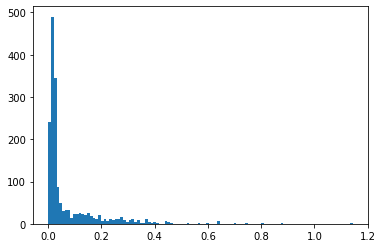

In [152]:

#filtered_orderbook = orderbook[(orderbook['type']=='fbProphet+strategy')]
#filtered_orderbook = orderbook[(orderbook['type']=='fbProphet')]
#filtered_orderbook = orderbook[(orderbook['type']==strategy)]
#filtered_orderbook = orderbook[(orderbook['type']=='trend')]
#filtered_orderbook = orderbook[(orderbook['type']=='MACD')]
#filtered_orderbook = orderbook[(orderbook['type']=='MACD') | (orderbook['type']==strategy)]
filtered_orderbook = orderbook[(orderbook['type']=='MACD') | (orderbook['type']=='fbProphet') | (orderbook['type']==strategy) | (orderbook['type']=='trend')]
#filtered_orderbook = orderbook[(orderbook['type']=='MACD') | (orderbook['type']=='fbProphet') | (orderbook['type']==strategy)]
#filtered_orderbook = orderbook[(orderbook['type']=='MACD') | (orderbook['type']=='fbProphet') | (orderbook['type']==strategy))]
#filtered_orderbook = orderbook[(orderbook['type']=='MACD') & (orderbook['estRet']>=.04) | (orderbook['type']=='fbProphet') | (orderbook['type']==strategy)]
#filtered_orderbook = orderbook[(orderbook['type']=='fbProphet') | (orderbook['type']==strategy)]
#filtered_orderbook = orderbook[(orderbook['type']=='MACD') & (orderbook['estRet']>=.04)]

#filtered_orderbook = orderbook[((orderbook['type']=='MACD') & (orderbook['estRet']>=.04) )| ((orderbook['type']=='fbProphet') | (orderbook['type']==strategy) |((orderbook['type']=='H') & (orderbook['estRet']>=1) )|( (orderbook['type']=='trend') & (orderbook['estRet']>=.9)) )]
#filtered_orderbook = filtered_orderbook.sort_values(by=['date','orderside','type'], ascending=True)
#display(filtered_orderbook.sort_values(by=['date','orderside','type'], ascending=True))
#display(filtered_orderbook)

plt.hist(filtered_orderbook['estRet'].dropna(), bins='auto')  # arguments are passed to np.histogram
#plt.hist(orderbook[orderbook['type']=='trend']['estRet'].dropna(), bins='auto')  # arguments are passed to np.histogram

In [153]:
filtered_orderbook.head().append(filtered_orderbook.tail())

,orderside,valueAtSale,date,valueAtPurchase,estRet,type,dateBought,dateToBeSold
0,buy,4134.4414,2018-12-16,3252.8391,1.1435,fbProphet,2018-12-16,2018-12-20
1,buy,3896.5437,2018-12-17,3545.8647,0.8837,fbProphet,2018-12-17,2018-12-21
2,buy,4014.1826,2018-12-18,3696.0591,0.7435,fbProphet,2018-12-18,2018-12-22
3,buy,4014.1826,2018-12-18,3696.0591,0.0144,trend,2018-12-18,2018-12-22
4,buy,3998.9802,2018-12-19,3745.9507,0.5221,fbProphet,2018-12-19,2018-12-23
1717,sell,47504.8516,2021-02-12,46196.4648,0.0224,MACD,2021-02-08,2021-02-12
1718,sell,47504.8516,2021-02-12,46196.4648,0.0222,trend,2021-02-08,2021-02-12
1719,sell,47105.5156,2021-02-13,46481.1055,0.0224,MACD,2021-02-09,2021-02-13
1720,sell,48717.2891,2021-02-14,44918.1836,0.0225,MACD,2021-02-10,2021-02-14
1721,sell,48717.2891,2021-02-14,44918.1836,0.0224,trend,2021-02-10,2021-02-14


In [154]:
len(filtered_orderbook)

1722

In [155]:
print(len(filtered_orderbook.sort_values(by=['date','orderside','type'], ascending=True)))
fobs = filtered_orderbook.sort_values(by=['date','orderside','type'], ascending=True)
fobs.head(10).append(fobs.tail(10))

1722


,orderside,valueAtSale,date,valueAtPurchase,estRet,type,dateBought,dateToBeSold
0,buy,4134.4414,2018-12-16,3252.8391,1.1435,fbProphet,2018-12-16,2018-12-20
1,buy,3896.5437,2018-12-17,3545.8647,0.8837,fbProphet,2018-12-17,2018-12-21
2,buy,4014.1826,2018-12-18,3696.0591,0.7435,fbProphet,2018-12-18,2018-12-22
3,buy,4014.1826,2018-12-18,3696.0591,0.0144,trend,2018-12-18,2018-12-22
4,buy,3998.9802,2018-12-19,3745.9507,0.5221,fbProphet,2018-12-19,2018-12-23
5,buy,3998.9802,2018-12-19,3745.9507,0.0148,trend,2018-12-19,2018-12-23
6,buy,4078.5991,2018-12-20,4134.4414,0.3644,fbProphet,2018-12-20,2018-12-24
7,buy,4078.5991,2018-12-20,4134.4414,0.0146,trend,2018-12-20,2018-12-24
861,sell,4134.4414,2018-12-20,3252.8391,1.1435,fbProphet,2018-12-16,2018-12-20
8,buy,3815.4907,2018-12-21,3896.5437,0.4432,fbProphet,2018-12-21,2018-12-25


In [156]:

funds = 1000
BuyFundsPercent = 1
percentHeldOnSell = 1

buyLog = pd.DataFrame()
sellLog = pd.DataFrame()
runningLog = pd.DataFrame()

held = 0
upper = 0
lower = 0

#weights = [3,2,1]

#weights2 = 1/np.array(weights)/sum(1/np.array(weights))

weights2 = [.125, .25, .75, .75]

for i in pd.DataFrame(frequency).set_index(0)[end_date1:end_date].index[:-1]:
#for i in pd.DataFrame(frequency).set_index(0)[end_date1:end_date].index:
    
    temp = pd.DataFrame()
    rtemp = pd.DataFrame()
    _temp = pd.DataFrame()
    
    t = i.strftime('%Y-%m-%d')
    
    subset = filtered_orderbook[filtered_orderbook['date']==t]
        
    gain = 0
    paid = 0

    if len(subset) != 0:
        #print()
        #print("date " + str(i))
        #print(subset)
        
        sales = subset[subset['orderside'] == 'sell']        
        types_s = sales['type'].unique()
        
        for ts_ in types_s:
            
            sales_t = sales[sales['type']==ts_]

            if len(sales_t) != 0:                        

                oldvalue = sales_t['valueAtPurchase'].values[0]

                newvalue = sales_t['valueAtSale'].values[0]      
                
                bl = buyLog.set_index('date').loc[sales_t['dateBought']]
                #buyLog.set_index('date').loc[datetime.datetime.strptime(sales_t['dateBought'].values[0], "%Y-%m-%d").date()]
                #buyLog.set_index('date').loc[sales_t['dateBought'].values[0]]
                
                if isinstance(bl, pd.Series):
                    bl = pd.DataFrame(bl).transpose()
                
                Qty = bl[bl['type']==ts_]['qty'][0]
                    
                gain = gain + (newvalue * Qty)

                _temp['date'] = [t]
                _temp['type'] = [ts_]
                _temp['qty'] = [Qty]
                
                sellLog = pd.concat([sellLog,_temp])                
    
        purchases = subset[subset['orderside'] == 'buy']
        
        types_p = purchases['type'].unique()
        
        for tp in types_p:
            
            purchases_t = purchases[purchases['type']==tp]

            if len(purchases_t) != 0:
                
                weights = [3,2,1]                

                #print(tp)                
                if tp == 'H': BuyFundsPercent_ = BuyFundsPercent * weights2[0]
                if tp == 'trend': BuyFundsPercent_ = BuyFundsPercent * weights2[1]
                if tp == 'MACD': BuyFundsPercent_ = BuyFundsPercent * weights2[2]                
                if tp == strategy: BuyFundsPercent_ = BuyFundsPercent * weights2[2]
                if tp == 'fbProphet': BuyFundsPercent_ = BuyFundsPercent * weights2[3]   
                if tp == 'fbProphet+strategy': BuyFundsPercent_ = BuyFundsPercent * weights2[3]   
                
                ProportionOfFunds = funds * BuyFundsPercent_

                Qty = ProportionOfFunds / purchases_t['valueAtPurchase'].values[0]
                Qty = Qty.round(6)
                #print(purchases['valueAtPurchase'].values[0])
                #print("Qty purchased " + str(Qty.round(2)))

                temp['date'] = [t]
                temp['type'] = [tp]
                temp['qty'] = [Qty]

                paid = purchases_t['valueAtPurchase'].values[0]*Qty
                
                #print("buy")
                #print(temp)

                buyLog = pd.concat([buyLog,temp])

                #print(buyLog)
                
                funds = funds - paid           

        funds = funds + gain
        
        rtemp['date'] =  [t]
        rtemp['funds'] =  [funds]
        
        if len(sellLog) != 0:
            remainder = (sum(buyLog['qty'])-sum(sellLog['qty']))            
            
        else:
            remainder = (sum(buyLog['qty']))
        
        rtemp['held'] = format(remainder,".6f")
        
        #print(remainder)
        rtemp['value'] = remainder * data.loc[t]['Close']
        rtemp['portValue'] = funds + remainder * data.loc[t]['Close']
        #print(rtemp)
                
        #print("in " + str(gain))
        #print("out " + str(paid))
        #print("held: " + str(remainder))
        #print("Close Value: " + str(data.loc[i]['Close']))
        #print("held Value: " + str(remainder * data.loc[i]['Close']))
        #print("funds " + str(funds))
        #print("portValue " + str(funds + remainder * data.loc[i]['Close']))
        #print()
            
        runningLog = runningLog.append(rtemp)
        
runningLog['date'] = pd.to_datetime(runningLog['date'], errors='coerce',format='%Y-%m-%d')        
        
funds = 1000                                                    
                

In [157]:

sellDates.head().append(sellDates.tail())

,date,qty,type
0,2018-12-20,NaN,fbProphet
1,2018-12-21,NaN,fbProphet
2,2018-12-22,NaN,fbProphet
3,2018-12-22,NaN,trend
4,2018-12-23,NaN,fbProphet
856,2021-02-12,NaN,MACD
857,2021-02-12,NaN,trend
858,2021-02-13,NaN,MACD
859,2021-02-14,NaN,MACD
860,2021-02-14,NaN,trend


In [158]:
#sellLog['orderSide'] = 'sale'
#sellLog['cumsum'] = cumsum(sellLog['qty'])
#buyLog['orderSide'] = 'buy'
#buyLog['cumsum'] = cumsum(buyLog['qty'])

In [159]:
len(orderbook[orderbook['orderside']=='buy'])-len(orderbook[orderbook['orderside']=='sell'])

0

In [160]:
#new = sellLog.append(buyLog).sort_values(by=['date'], ascending=True)
#new[new['orderSide']=='sale']
#new

In [161]:
#if end_date.strftime('%Y-%m-%d') != runningLog['date'].iloc[-1].strftime('%Y-%m-%d'):
if end_date.strftime('%Y-%m-%d') != runningLog['date'].iloc[-1].date().strftime('%Y-%m-%d'):
    #end_date.strftime('%Y-%m-%d') != runningLog['date'].iloc[-1]:
    rl_temp = pd.DataFrame()
    rl_temp['date'] = [end_date.strftime('%Y-%m-%d')]
    rl_temp['funds'] = [runningLog.iloc[-1]['funds']]
    rl_temp['held'] = [runningLog.iloc[-1]['held']]
    rl_temp['value'] = [runningLog.iloc[-1]['value']]
    rl_temp['portValue'] = [runningLog.iloc[-1]['portValue']]
    runningLog = runningLog.append(rl_temp)
    runningLog['date'] = pd.to_datetime(runningLog['date'], errors='coerce',format='%Y-%m-%d')
    
    runningLog = runningLog.sort_values(by=['date'], ascending=True)
    
if end_date1.strftime('%Y-%m-%d') != runningLog['date'].iloc[0].strftime('%Y-%m-%d'):
    rl_temp = pd.DataFrame()
    rl_temp['date'] = [end_date1.strftime('%Y-%m-%d')]
    rl_temp['funds'] = [funds]
    rl_temp['held'] = [0]
    rl_temp['value'] = [0]
    rl_temp['portValue'] = [funds]
    runningLog = runningLog.append(rl_temp)
    runningLog['date'] = pd.to_datetime(runningLog['date'], errors='coerce',format='%Y-%m-%d')

    runningLog = runningLog.sort_values(by=['date'], ascending=True)


In [162]:

runningLog.head().append(runningLog.tail())

,date,funds,held,value,portValue
0,2018-12-16,249.999394,0.230568,750.000608,1000.000003
0,2018-12-17,62.501161,0.283446,1005.061179,1067.562340
0,2018-12-18,11.717309,0.297186,1098.417014,1110.134323
0,2018-12-19,2.198848,0.299727,1122.762561,1124.961409
0,2018-12-20,953.682654,0.069591,287.719912,1241.402566
0,2021-02-11,2509.286954,0.139107,6664.523451,9173.810405
0,2021-02-12,3418.197280,0.119974,5699.347061,9117.544341
0,2021-02-13,5888.504729,0.067532,3181.129681,9069.634410
0,2021-02-14,9178.480696,0.000000,0.000000,9178.480696
0,2021-03-14,9178.480696,0.000000,0.000000,9178.480696


In [163]:
ret_data =  runningLog.set_index(pd.to_datetime(runningLog['date'], format='%Y-%m-%d'))['portValue'].pct_change()
#ret_data['date'] = pd.to_datetime(runningLog['date'], format='%Y-%m-%d')

ret_data.head().append(ret_data.tail())

date
2018-12-16         NaN
2018-12-17    0.067562
2018-12-18    0.039878
2018-12-19    0.013356
2018-12-20    0.103507
2021-02-11    0.051334
2021-02-12   -0.006133
2021-02-13   -0.005255
2021-02-14    0.012001
2021-03-14    0.000000
Name: portValue, dtype: float64

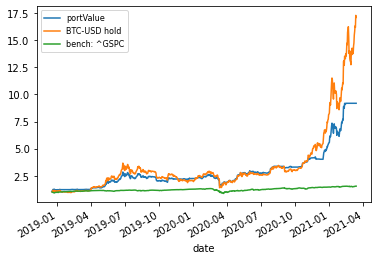

9.178480672203817


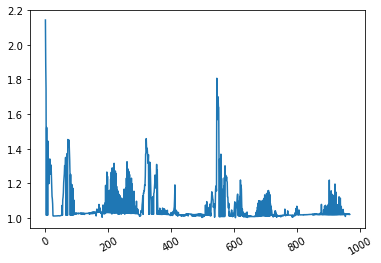

9.178480672203817
2.524539856906504


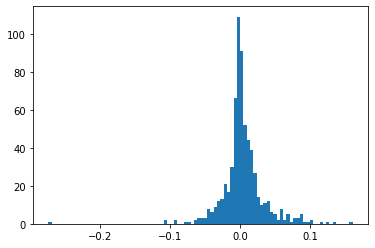

In [164]:

#ret_data =  runningLog.set_index('date')['portValue'].pct_change()
ret_data =  runningLog.set_index(pd.to_datetime(runningLog['date'], format='%Y-%m-%d'))['portValue'].pct_change()
cumulative_ret_data = (ret_data + 1).cumprod()

#data
ret_data2 = data[runningLog.set_index('date').index[1]:runningLog.set_index('date').index[-1]]['Close'].pct_change()
cum_ret_data2 = (ret_data2 + 1).cumprod()

#benchData
sp500_data = benchData[runningLog.set_index('date').index[1]:runningLog.set_index('date').index[-1]]['Close'].pct_change()
sp500_cumulative_ret_data = (sp500_data + 1).cumprod()

cumulative_ret_data.dropna().plot()

plt.plot(cum_ret_data2,label=name + " hold")
plt.plot(sp500_cumulative_ret_data,label="bench: " + benchName)
plt.legend(loc="upper left",fontsize=8)

plt.xticks(rotation=30) 

plt.show()

print(cumulative_ret_data[-1])

plt.plot((set['ExpectedReturn']+1))
plt.xticks(rotation=30) 
#len(set['ExpectedReturn']+1)

runningLog

plt.show()
print(cumulative_ret_data.iloc[-1])
plt.hist(runningLog.set_index('date')['portValue'].pct_change().dropna(), bins='auto')  # arguments are passed to np.histogram
print(runningLog['portValue'].dropna().pct_change().sum())

